In [1]:
using Mamba, HDF5, JLD, BenchmarkTools

# Test 3: Matrix Multiplication

$f(\theta) = A \theta $


In [2]:
#A = randn(20,30)
#save("data.jld", "data", A)
A = load("data.jld")["data"];

In [3]:
n = 30

function ff!(θ::AbstractVector, jac::AbstractMatrix)
    if length(jac) > 0
        jac[:]=A
    end
    
    return A*θ
end

ff! (generic function with 1 method)

### Using RTO

In [4]:
include("../RandomizeThenOptimize.jl")
using RandomizeThenOptimize

In [5]:
p = Problem(n,20)
forward_model!(p,ff!)

ff! (generic function with 1 method)

In [6]:
nsamps = 10000;

In [7]:
chain = rto_mcmc(p,nsamps);
b = @benchmark rto_mcmc(p,nsamps);
tseconds = mean(b).time / 1e9

41.4248125

In [8]:
sim = Chains(nsamps,n,names=[string("theta_",i) for i = 1:n]);
sim[:,:,1] = chain;

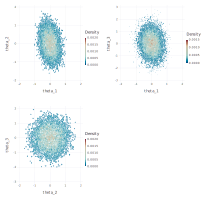

In [9]:
plt = Mamba.plot(sim[:,1:3,1],:contour,legend=true);
draw(plt,nrow=2,ncol=2)

In [10]:
ESS = summarystats(sim).value[1,end,1]
ESSpertime = ESS / tseconds

241.40121334284856

### Using MALA

In [11]:
nsamps_mala = nsamps*10;
sim_mala = Chains(nsamps_mala,n,names=[string("θ_",i) for i = 1:n]);
θ_mala = MALAVariate(zeros(n), 0.01, x->logpostgrad(x,p));

In [12]:
sample!(θ_mala)
b = @benchmark for i in 1:nsamps_mala
    sample!(θ_mala)
    sim_mala[i, :, 1] = θ_mala;
end
tseconds = mean(b).time / 1e9

6.380732568

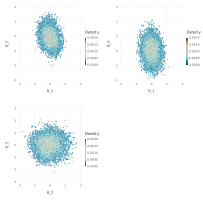

In [13]:
plt = Mamba.plot(sim_mala[1:10:end,1:3,1],:contour,legend=true);
draw(plt, nrow=2,ncol=2)

In [14]:
ESS = summarystats(sim_mala).value[1,end,1]
ESSpertime = ESS/tseconds

230.45656058151323

### Using HMC

In [15]:
sim_hmc = Chains(nsamps,n,names=[string("θ_",i) for i = 1:n]);
θ_hmc = HMCVariate(zeros(n), 0.01, 50, x->logpostgrad(x,p));

In [16]:
sample!(θ_hmc)
b = @benchmark for i in 1:nsamps
    sample!(θ_hmc)
    sim_hmc[i, :, 1] = θ_hmc;
end
tseconds = mean(t).time / 1e9

LoadError: LoadError: UndefVarError: t not defined
while loading In[16], in expression starting on line 6

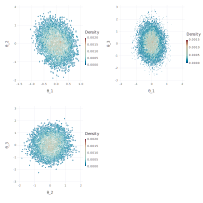

In [17]:
plt = Mamba.plot(sim_hmc[:,1:3,1],:contour,legend=true);
draw(plt, nrow=2,ncol=2 )

In [18]:
ESS = summarystats(sim_hmc).value[1,end,1]
ESSpertime = ESS/tseconds

212.0098446181018